# Using Knowledge Graphs to Predict Association Football match outcome

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd /content/drive/MyDrive/Bharani/HSE_Thesis

/content/drive/MyDrive/Bharani/HSE_Thesis


In [11]:
# !pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install torch-geometric
# !pip install networkx
# !pip install torchkge
# !pip install xgboost

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import networkx as nx
import torch_geometric
import torchkge
from torchkge.models import TransEModel
from torchkge.models import  ComplExModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, DataLoader
from torchkge.data_structures import KnowledgeGraph
from torch import cuda
from tqdm.autonotebook import tqdm
from torch.optim import Adam
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchkge.utils.pretrained_models import load_pretrained_transe
from torchkge.evaluation import LinkPredictionEvaluator
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from scipy.stats import poisson
import seaborn as sebrn
import matplotlib.pyplot as atlas
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
ls

KGE_Poisson.ipynb       matches_epl.csv      matches_ligue_1.csv
matches_bundesliga.csv  matches_la_liga.csv  matches_seria_A.csv


# Data_for_each_FA

In [14]:
df_epl = pd.read_csv("matches_epl.csv")
df_bundesliga = pd.read_csv("matches_bundesliga.csv")
df_la_liga = pd.read_csv("matches_la_liga.csv")
df_ligue_1 = pd.read_csv("matches_ligue_1.csv")
df_seria_a = pd.read_csv("matches_seria_A.csv")

In [15]:
df_epl.shape, df_bundesliga.shape, df_la_liga.shape, df_ligue_1.shape, df_seria_a.shape

((8284, 25), (6698, 25), (8360, 25), (8360, 25), (8360, 25))

Comment: 

1) The number of matches in epl dataset = 8284

2) The number of matches in bundesliga dataset = 6698

3) The number of matches in la liga dataset = 8360

4) The number of matches in ligue 1 dataset = 8360

5) The number of matches in seria a dataset = 8360

In [16]:
df = df_la_liga.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Alavés": "Alaves", 
              "Almería": "Almeria", 
              "Atlético Madrid": "Atletico Madrid", 
              "Cádiz": "Cadiz", 
              "La Coruña": "Deportivo La Coruna", 
              "Leganés": "Leganes", 
              'Málaga':'Malaga',
              'Betis': 'Real Betis'}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]
df['train'].value_counts(normalize=True)

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (3233, 24)


True     0.801114
False    0.198886
Name: train, dtype: float64

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
result,3233.0,0.993504,0.849225,0.0,0.0,1.0,2.0,2.0
gf,3233.0,1.269100,1.164646,0.0,0.0,1.0,2.0,8.0
ga,3233.0,1.305289,1.201237,0.0,0.0,1.0,2.0,8.0
xg,3233.0,1.299103,0.770164,0.0,0.7,1.2,1.7,5.3
xga,3233.0,1.324992,0.795198,0.0,0.7,1.2,1.8,5.6
poss_x,3233.0,49.190844,11.016292,18.0,41.0,49.0,57.0,81.0
attendance,3233.0,26433.862357,16420.608429,13.0,15110.0,27210.0,29679.0,97939.0
sh_x,3233.0,11.456233,4.690616,0.0,8.0,11.0,14.0,33.0
sot_x,3233.0,3.811011,2.274450,0.0,2.0,4.0,5.0,17.0
dist_x,3233.0,18.310145,3.362078,4.8,16.1,18.2,20.2,46.2


# La Liga

## KG - La Liga

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (3233, 24)
(61427, 3)
(61427, 3)
           from                     rel           to
76  Matchweek 6           was_played_on   2022-09-17
77  Matchweek 6           was_played_at      Evening
78  Matchweek 6       was_played_on_day     Saturday
79  Matchweek 6      belonged_to_season         2023
80    Barcelona              is_home_on  Matchweek 6
81        Elche              is_away_on  Matchweek 6
82    Barcelona   has_expected_goals_as          3.9
83        Elche   has_expected_goals_as          0.0
84    Barcelona       has_possession_as         76.0
85        Elche       has_possession_as         24.0
86    Barcelona          had_attendance        85073
87    Barcelona           had_formation        4-3-3
88 

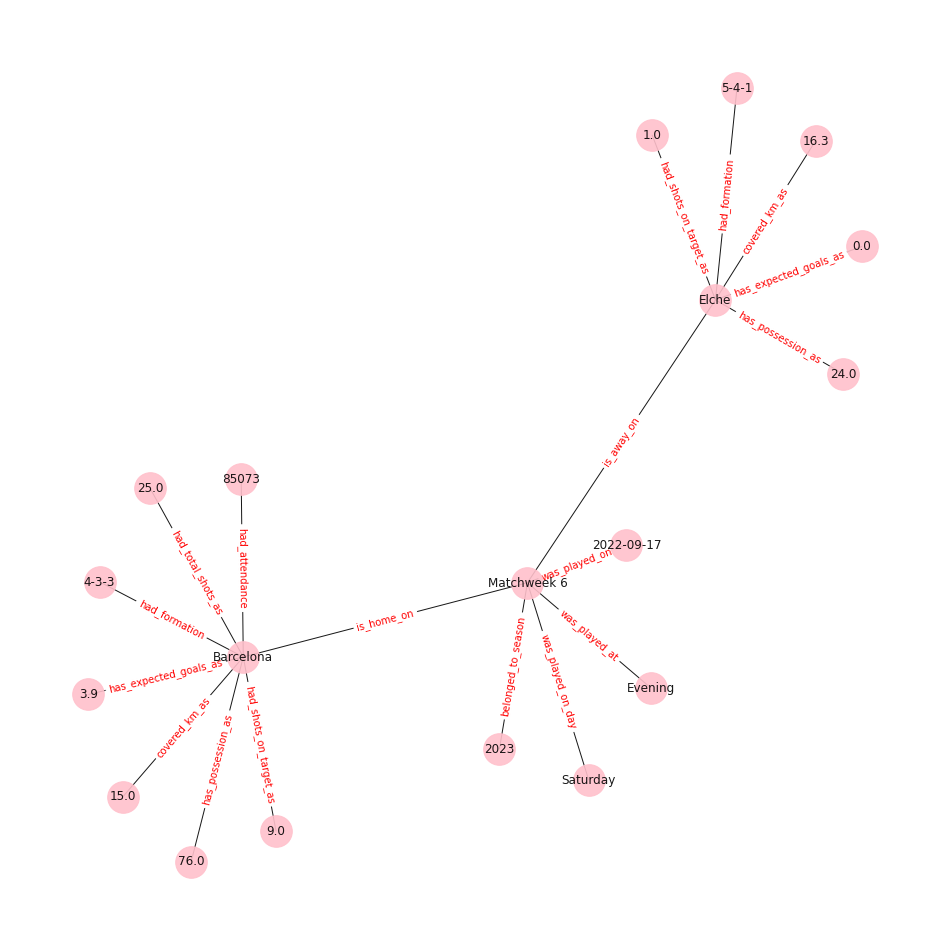

In [18]:
df = df_la_liga.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Alavés": "Alaves", 
              "Almería": "Almeria", 
              "Atlético Madrid": "Atletico Madrid", 
              "Cádiz": "Cadiz", 
              "La Coruña": "Deportivo La Coruna", 
              "Leganés": "Leganes", 
              'Málaga':'Malaga',
              'Betis': 'Real Betis'}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]

triples = []
for _, row in df.iterrows():
    # match_info
    match_played_date = (row["round"], "was_played_on", row["date"])
    match_played_time = (row["round"], "was_played_at", row["time"])
    match_played_day = (row["round"], "was_played_on_day", row["day"])
    match_played_season = (row["round"], "belonged_to_season", row["season"])

    # Home and away information
    if row["venue"] == 'Home':
        match_attendance = (row["team"], "had_attendance", row["attendance"])
        home_team = (row["team"], "is_home_on", row["round"])
        away_team = (row["opponent"], "is_away_on", row["round"])
        home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        home_team_formation = (row["team"], "had_formation", row["formation_x"])
        away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
    else:
        match_attendance = (row["opponent"], "had_attendance", row["attendance"])
        home_team = (row["opponent"], "is_home_on", row["round"])
        away_team = (row["team"], "is_away_on", row["round"])
        home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        away_team_formation = (row["team"], "had_formation", row["formation_x"])

    
    triples.extend((match_played_date, 
                    match_played_time, 
                    match_played_day, 
                    match_played_season, 
                    home_team, away_team,
                    home_team_xg, away_team_xg,
                    home_team_poss, away_team_poss,
                    match_attendance, 
                    home_team_formation, away_team_formation, 
                    home_team_shots, away_team_shots, 
                    home_team_shots_on_target, away_team_shots_on_target, 
                    home_team_distance_covered, away_team_distance_covered, 
                    ))
    
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
print(triples_df.shape)

to_visualize_edges = triples_df[76:95]
print(triples_df.shape)
print(to_visualize_edges)

edge_list = []
edge_labels = {}
for _, row in to_visualize_edges.iterrows():
    h, r, t = row['from'], row['rel'], row['to']
    edge_list.append([h, t])
    edge_labels[(h, t)] = r

G = nx.Graph()
G.add_edges_from(edge_list)
pos = nx.spring_layout(G)
plt.figure(figsize=(13, 13))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)

plt.axis('off')
plt.show()

In [19]:
# G = nx.from_pandas_edgelist(to_visualize_edges, source='from', target='to', create_using=nx.MultiDiGraph(), edge_attr='rel')
# plt.figure(figsize=(13, 13))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', pos=pos)
# nx.draw_networkx_edge_labels(G, pos=pos)
# plt.show()

triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
triples_df = pd.DataFrame(triples_df, columns=['from', 'to', 'rel'])
kg_train = torchkge.data_structures.KnowledgeGraph(triples_df)
ent2ix = kg_train.ent2ix
rel2ix = kg_train.rel2ix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Hyper-parameters for Training to learn the embeddings
emb_dim = 100 # dimension of the tensor in the latent space
lr = 0.005 # learning rate to make gradient step 
n_epochs = 1000 # number of epochs
b_size = 1024 # size of data for each batch
margin = 0.5 # margin for the loss function

# Model and loss function
# model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
model = ComplExModel(emb_dim, kg_train.n_ent, kg_train.n_rel)
criterion = MarginLoss(margin)

# Use CUDA when available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
    print("USING CUDA")
else:
    print("POOR CPU")

# train with optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# negative samples for training to make sure we dont predict unwanted links
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=device)

# training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        if cuda.is_available():
            pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
        else:
            pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

Using device:  cuda:0
USING CUDA


  0%|          | 0/1000 [00:00<?, ?epoch/s]

In [20]:
if "ComplExModel" in str(model):
    re_ent_emb, im_ent_emb, re_rel_emb, im_rel_emb = model.get_embeddings()
    ent_emb = torch.hstack((re_ent_emb, im_ent_emb))
    rel_emb = torch.hstack((re_rel_emb, im_rel_emb))
else:
    ent_emb, rel_emb = model.get_embeddings()
	
entity_embedding_dict = {}
for k, v in ent2ix.items():
    entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

relation_embedding_dict = {}
for k, v in rel2ix.items():
    relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

def get_embeddings(team):
    return entity_embedding_dict.get(team, np.full(200, np.nan))

def get_features_target(mask):
    features = np.hstack((
                    np.vstack(df[mask].team.apply(get_embeddings).values),
                    np.vstack(df[mask].opponent.apply(get_embeddings).values)
                    ))
    response = df[mask].result.values
    return features, response

clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((df["test"]))

In [21]:
ent_emb.shape, rel_emb.shape

(torch.Size([2613, 200]), torch.Size([13, 200]))

Comment: 

The learned embeddings of just team names are fed into the classifier for the prediction

In [22]:
clf_model = XGBClassifier(n_estimators=100, max_depth=5, objective="multi:softmax", verbose=True)
clf_model.fit(clf_X_train, y_train)
y_preds = clf_model.predict(clf_X_test)
print(accuracy_score(y_test, y_preds))

0.45878693623639194


In [23]:
print(df[df["test"]].result.value_counts(normalize=True))
print(result_label_as_int)
int_to_result = {v: k for k, v in result_label_as_int.items()}
print(int_to_result)
y_test_str = [int_to_result[outcome] for outcome in y_test]
y_preds_str = [int_to_result[outcome] for outcome in y_preds]

0    0.374806
2    0.367030
1    0.258165
Name: result, dtype: float64
{'W': 2, 'D': 1, 'L': 0}
{2: 'W', 1: 'D', 0: 'L'}


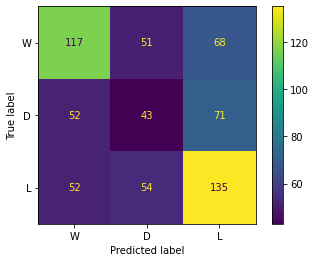

In [24]:
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

## Poisson - La Liga

0.46566731141199225


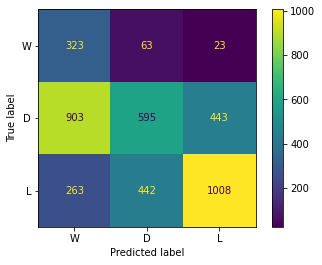

In [ ]:
df = df_la_liga.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Alavés": "Alaves", 
              "Almería": "Almeria", 
              "Atlético Madrid": "Atletico Madrid", 
              "Cádiz": "Cadiz", 
              "La Coruña": "Deportivo La Coruna", 
              "Leganés": "Leganes", 
              'Málaga':'Malaga',
              'Betis': 'Real Betis'}

mapping = Missing_Dict(**map_values)
df["team"] = df["team"].map(mapping)
df["opponent"] = df["opponent"].map(mapping)
# add a home advantage bias
bias = 0.2
df['xg'] = df["xg"] + bias
# expected goals is our lambda parameter for poisson distribution
total_goals_possible = [*range(0,11)]
points_home = []
points_away = []
for _, row in df.iterrows():
    home_lambda = row["xg"]
    away_lambda = row["xga"]
    home_win_prob, away_win_prob, draw_prob = 0, 0, 0
    for home_goals in total_goals_possible:
        for away_goals in total_goals_possible:
            p = poisson.pmf(home_goals, home_lambda) * poisson.pmf(away_goals, away_lambda)
            if home_goals > away_goals: home_win_prob += p
            elif home_goals == away_goals: draw_prob += p
            else: away_win_prob += p

    home_points = 3 * home_win_prob + draw_prob
    away_points = 3 * away_win_prob + draw_prob
    points_home.append(home_points), points_away.append(away_points)

df['points_home'], df['points_away'] = points_home, points_away
df['points_diff'] = df['points_home'] - df['points_away']
points_conditions = [
    ((df['points_diff'] > 0) & (df['points_diff'] > 2)),
    ((df['points_diff'] > 0) & (df['points_diff'] < 2)),
    (df['points_diff'] < 0),
]

cat_values = ['W', 'D', 'L']
df['result_poisson'] = np.select(points_conditions, cat_values)
print(accuracy_score(df['result'], df['result_poisson']))
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
int_to_result = {v: k for k, v in result_label_as_int.items()}
y_test_str = df['result_poisson'].tolist()
y_preds_str =df['result'].tolist()
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

# Seria A

## KG - Seria A

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (3952, 24)
(75088, 3)
(75088, 3)
           from                     rel           to
76  Matchweek 5           was_played_on   2022-09-03
77  Matchweek 5           was_played_at        Night
78  Matchweek 5       was_played_on_day     Saturday
79  Matchweek 5      belonged_to_season         2023
80        Lazio              is_home_on  Matchweek 5
81       Napoli              is_away_on  Matchweek 5
82        Lazio   has_expected_goals_as          0.3
83       Napoli   has_expected_goals_as          2.1
84        Lazio       has_possession_as         39.0
85       Napoli       has_possession_as         61.0
86        Lazio          had_attendance        39000
87        Lazio           had_formation        4-3-3
88 

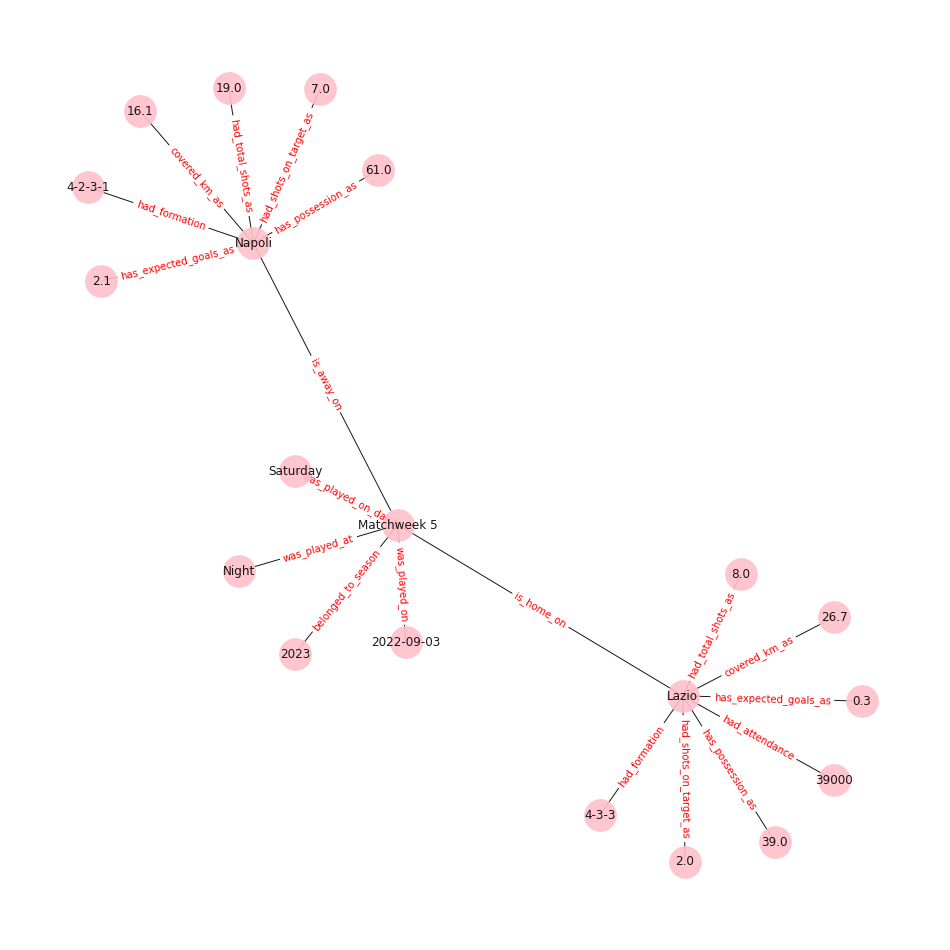

Using device:  cuda:0
USING CUDA


  0%|          | 0/1000 [00:00<?, ?epoch/s]

0.489873417721519
2    0.373418
0    0.348101
1    0.278481
Name: result, dtype: float64
{'W': 2, 'D': 1, 'L': 0}
{2: 'W', 1: 'D', 0: 'L'}


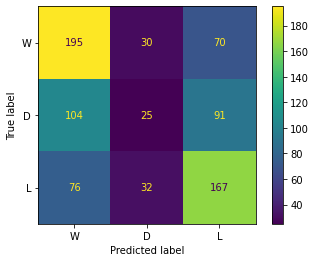

In [25]:
df = df_seria_a.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Internazionale": "Inter",}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]

triples = []
for _, row in df.iterrows():
    # match_info
    match_played_date = (row["round"], "was_played_on", row["date"])
    match_played_time = (row["round"], "was_played_at", row["time"])
    match_played_day = (row["round"], "was_played_on_day", row["day"])
    match_played_season = (row["round"], "belonged_to_season", row["season"])

    # Home and away information
    if row["venue"] == 'Home':
        match_attendance = (row["team"], "had_attendance", row["attendance"])
        home_team = (row["team"], "is_home_on", row["round"])
        away_team = (row["opponent"], "is_away_on", row["round"])
        home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        home_team_formation = (row["team"], "had_formation", row["formation_x"])
        away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
    else:
        match_attendance = (row["opponent"], "had_attendance", row["attendance"])
        home_team = (row["opponent"], "is_home_on", row["round"])
        away_team = (row["team"], "is_away_on", row["round"])
        home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        away_team_formation = (row["team"], "had_formation", row["formation_x"])

    
    triples.extend((match_played_date, 
                    match_played_time, 
                    match_played_day, 
                    match_played_season, 
                    home_team, away_team,
                    home_team_xg, away_team_xg,
                    home_team_poss, away_team_poss,
                    match_attendance, 
                    home_team_formation, away_team_formation, 
                    home_team_shots, away_team_shots, 
                    home_team_shots_on_target, away_team_shots_on_target, 
                    home_team_distance_covered, away_team_distance_covered, 
                    ))
    
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
print(triples_df.shape)

to_visualize_edges = triples_df[76:95]
print(triples_df.shape)
print(to_visualize_edges)

edge_list = []
edge_labels = {}
for _, row in to_visualize_edges.iterrows():
    h, r, t = row['from'], row['rel'], row['to']
    edge_list.append([h, t])
    edge_labels[(h, t)] = r

G = nx.Graph()
G.add_edges_from(edge_list)
pos = nx.spring_layout(G)
plt.figure(figsize=(13, 13))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)

plt.axis('off')
plt.show()

# G = nx.from_pandas_edgelist(to_visualize_edges, source='from', target='to', create_using=nx.MultiDiGraph(), edge_attr='rel')
# plt.figure(figsize=(13, 13))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', pos=pos)
# nx.draw_networkx_edge_labels(G, pos=pos)
# plt.show()

triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
triples_df = pd.DataFrame(triples_df, columns=['from', 'to', 'rel'])
kg_train = torchkge.data_structures.KnowledgeGraph(triples_df)
ent2ix = kg_train.ent2ix
rel2ix = kg_train.rel2ix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Hyper-parameters for Training to learn the embeddings
emb_dim = 100 # dimension of the tensor in the latent space
lr = 0.005 # learning rate to make gradient step 
n_epochs = 1000 # number of epochs
b_size = 1024 # size of data for each batch
margin = 0.5 # margin for the loss function

# Model and loss function
# model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
model = ComplExModel(emb_dim, kg_train.n_ent, kg_train.n_rel)
criterion = MarginLoss(margin)

# Use CUDA when available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
    print("USING CUDA")
else:
    print("POOR CPU")

# train with optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# negative samples for training to make sure we dont predict unwanted links
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=device)

# training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        if cuda.is_available():
            pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
        else:
            pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

if "ComplExModel" in str(model):
    re_ent_emb, im_ent_emb, re_rel_emb, im_rel_emb = model.get_embeddings()
    ent_emb = torch.hstack((re_ent_emb, im_ent_emb))
    rel_emb = torch.hstack((re_rel_emb, im_rel_emb))
else:
    ent_emb, rel_emb = model.get_embeddings()
	
entity_embedding_dict = {}
for k, v in ent2ix.items():
    entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

relation_embedding_dict = {}
for k, v in rel2ix.items():
    relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

def get_embeddings(team):
    return entity_embedding_dict.get(team, np.full(200, np.nan))

def get_features_target(mask):
    features = np.hstack((np.vstack(df[mask].team.apply(get_embeddings).values),
                   np.vstack(df[mask].opponent.apply(get_embeddings).values)))
    response = df[mask].result.values
    return features, response

clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((df["test"]))

clf_model = XGBClassifier(n_estimators=100, max_depth=5, objective="multi:softmax", verbose=True)
clf_model.fit(clf_X_train, y_train)
y_preds = clf_model.predict(clf_X_test)
print(accuracy_score(y_test, y_preds))

print(df[df["test"]].result.value_counts(normalize=True))
print(result_label_as_int)
int_to_result = {v: k for k, v in result_label_as_int.items()}
print(int_to_result)
y_test_str = [int_to_result[outcome] for outcome in y_test]
y_preds_str = [int_to_result[outcome] for outcome in y_preds]

cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

## Poisson - Seria A

0.4774038461538462


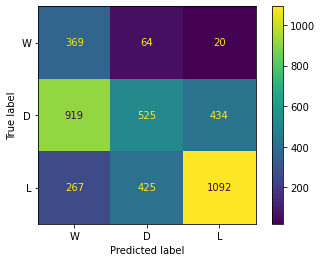

In [ ]:
df = df_seria_a.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)425
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Internazionale": "Inter",}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)

# add a home advantage bias
bias = 0.2
df['xg'] = df["xg"] + bias

# expected goals is our lambda parameter for poisson distribution
total_goals_possible = [*range(0,11)]
points_home = []
points_away = []
for _, row in df.iterrows():
    home_lambda = row["xg"]
    away_lambda = row["xga"]
    home_win_prob, away_win_prob, draw_prob = 0, 0, 0
    for home_goals in total_goals_possible:
        for away_goals in total_goals_possible:
            p = poisson.pmf(home_goals, home_lambda) * poisson.pmf(away_goals, away_lambda)
            if home_goals > away_goals: home_win_prob += p
            elif home_goals == away_goals: draw_prob += p
            else: away_win_prob += p

    home_points = 3 * home_win_prob + draw_prob
    away_points = 3 * away_win_prob + draw_prob
    points_home.append(home_points), points_away.append(away_points)

df['points_home'], df['points_away'] = points_home, points_away

df['points_diff'] = df['points_home'] - df['points_away']

points_conditions = [
    ((df['points_diff'] > 0) & (df['points_diff'] > 2)),
    ((df['points_diff'] > 0) & (df['points_diff'] < 2)),
    (df['points_diff'] < 0),
]


cat_values = ['W', 'D', 'L']
df['result_poisson'] = np.select(points_conditions, cat_values)
print(accuracy_score(df['result'], df['result_poisson']))
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
int_to_result = {v: k for k, v in result_label_as_int.items()}
y_test_str = df['result_poisson'].tolist()
y_preds_str =df['result'].tolist()
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

# EPL

## KG - EPL

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (2715, 24)
(51585, 3)
(51585, 3)
           from                     rel           to
76  Matchweek 5           was_played_on   2022-08-31
77  Matchweek 5           was_played_at        Night
78  Matchweek 5       was_played_on_day    Wednesday
79  Matchweek 5      belonged_to_season         2023
80      Arsenal              is_home_on  Matchweek 5
81  Aston Villa              is_away_on  Matchweek 5
82      Arsenal   has_expected_goals_as          2.4
83  Aston Villa   has_expected_goals_as          0.4
84      Arsenal       has_possession_as         59.0
85  Aston Villa       has_possession_as         41.0
86      Arsenal          had_attendance        60012
87      Arsenal           had_formation        4-3-3
88 

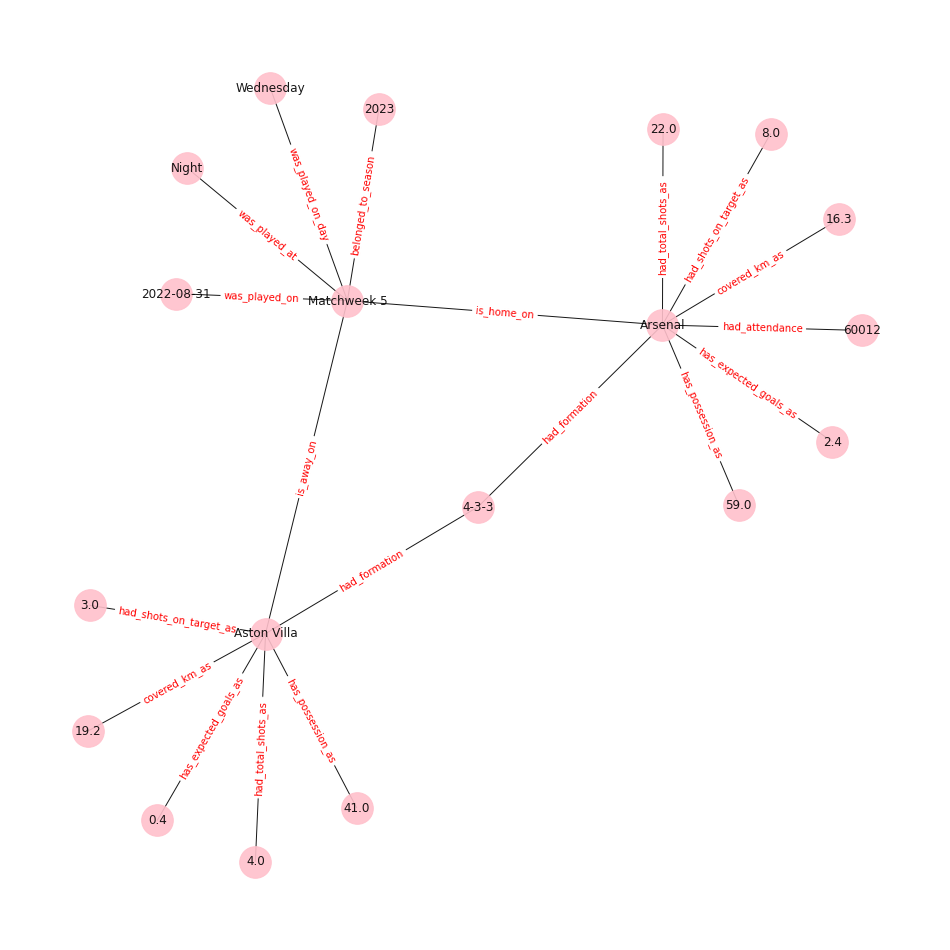

Using device:  cuda:0
USING CUDA


  0%|          | 0/1000 [00:00<?, ?epoch/s]

0.4822934232715008
2    0.411467
0    0.377740
1    0.210793
Name: result, dtype: float64
{'W': 2, 'D': 1, 'L': 0}
{2: 'W', 1: 'D', 0: 'L'}


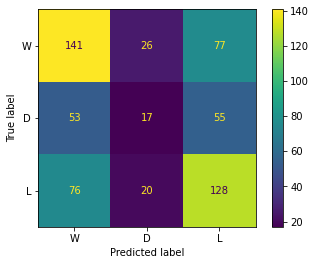

In [26]:
df = df_epl.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Manchester United": "Manchester Utd", 
              'Queens Park Rangers': "QPR", 
              'Newcastle United': "Newcastle Utd", 
              'Huddersfield Town': "Huddersfield", 
              'Brighton and Hove Albion': "Brighton", 
              "West Ham United": 'West Ham', 
              'Tottenham Hotspur':'Tottenham',
              'West Bromwich Albion': 'West Brom',
              'Sheffield United': 'Sheffield Utd',
              "Nott'ham Forest": 'Nottingham Forest',
              'Wolverhampton Wanderers':'Wolves'}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]

triples = []
for _, row in df.iterrows():
    # match_info
    match_played_date = (row["round"], "was_played_on", row["date"])
    match_played_time = (row["round"], "was_played_at", row["time"])
    match_played_day = (row["round"], "was_played_on_day", row["day"])
    match_played_season = (row["round"], "belonged_to_season", row["season"])

    # Home and away information
    if row["venue"] == 'Home':
        match_attendance = (row["team"], "had_attendance", row["attendance"])
        home_team = (row["team"], "is_home_on", row["round"])
        away_team = (row["opponent"], "is_away_on", row["round"])
        home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        home_team_formation = (row["team"], "had_formation", row["formation_x"])
        away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
    else:
        match_attendance = (row["opponent"], "had_attendance", row["attendance"])
        home_team = (row["opponent"], "is_home_on", row["round"])
        away_team = (row["team"], "is_away_on", row["round"])
        home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        away_team_formation = (row["team"], "had_formation", row["formation_x"])

    
    triples.extend((match_played_date, 
                    match_played_time, 
                    match_played_day, 
                    match_played_season, 
                    home_team, away_team,
                    home_team_xg, away_team_xg,
                    home_team_poss, away_team_poss,
                    match_attendance, 
                    home_team_formation, away_team_formation, 
                    home_team_shots, away_team_shots, 
                    home_team_shots_on_target, away_team_shots_on_target, 
                    home_team_distance_covered, away_team_distance_covered, 
                    ))
    
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
print(triples_df.shape)

to_visualize_edges = triples_df[76:95]
print(triples_df.shape)
print(to_visualize_edges)

edge_list = []
edge_labels = {}
for _, row in to_visualize_edges.iterrows():
    h, r, t = row['from'], row['rel'], row['to']
    edge_list.append([h, t])
    edge_labels[(h, t)] = r

G = nx.Graph()
G.add_edges_from(edge_list)
pos = nx.spring_layout(G)
plt.figure(figsize=(13, 13))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)

plt.axis('off')
plt.show()

# G = nx.from_pandas_edgelist(to_visualize_edges, source='from', target='to', create_using=nx.MultiDiGraph(), edge_attr='rel')
# plt.figure(figsize=(13, 13))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', pos=pos)
# nx.draw_networkx_edge_labels(G, pos=pos)
# plt.show()

triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
triples_df = pd.DataFrame(triples_df, columns=['from', 'to', 'rel'])
kg_train = torchkge.data_structures.KnowledgeGraph(triples_df)
ent2ix = kg_train.ent2ix
rel2ix = kg_train.rel2ix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Hyper-parameters for Training to learn the embeddings
emb_dim = 100 # dimension of the tensor in the latent space
lr = 0.005 # learning rate to make gradient step 
n_epochs = 1000 # number of epochs
b_size = 1024 # size of data for each batch
margin = 0.5 # margin for the loss function

# Model and loss function
# model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
model = ComplExModel(emb_dim, kg_train.n_ent, kg_train.n_rel)
criterion = MarginLoss(margin)

# Use CUDA when available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
    print("USING CUDA")
else:
    print("POOR CPU")

# train with optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# negative samples for training to make sure we dont predict unwanted links
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=device)

# training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        if cuda.is_available():
            pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
        else:
            pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

if "ComplExModel" in str(model):
    re_ent_emb, im_ent_emb, re_rel_emb, im_rel_emb = model.get_embeddings()
    ent_emb = torch.hstack((re_ent_emb, im_ent_emb))
    rel_emb = torch.hstack((re_rel_emb, im_rel_emb))
else:
    ent_emb, rel_emb = model.get_embeddings()
	
entity_embedding_dict = {}
for k, v in ent2ix.items():
    entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

relation_embedding_dict = {}
for k, v in rel2ix.items():
    relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

def get_embeddings(team):
    return entity_embedding_dict.get(team, np.full(200, np.nan))

def get_features_target(mask):
    features = np.hstack((np.vstack(df[mask].team.apply(get_embeddings).values),
                   np.vstack(df[mask].opponent.apply(get_embeddings).values)))
    response = df[mask].result.values
    return features, response

clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((df["test"]))

clf_model = XGBClassifier(n_estimators=100, max_depth=5, objective="multi:softmax", verbose=True)
clf_model.fit(clf_X_train, y_train)
y_preds = clf_model.predict(clf_X_test)
print(accuracy_score(y_test, y_preds))

print(df[df["test"]].result.value_counts(normalize=True))
print(result_label_as_int)
int_to_result = {v: k for k, v in result_label_as_int.items()}
print(int_to_result)
y_test_str = [int_to_result[outcome] for outcome in y_test]
y_preds_str = [int_to_result[outcome] for outcome in y_preds]

cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

## Poisson - EPL

0.4906653901388224


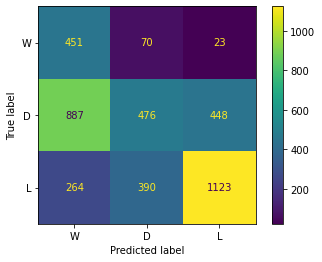

In [ ]:

df = df_epl.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Manchester United": "Manchester Utd", 
              'Queens Park Rangers': "QPR", 
              'Newcastle United': "Newcastle Utd", 
              'Huddersfield Town': "Huddersfield", 
              'Brighton and Hove Albion': "Brighton", 
              "West Ham United": 'West Ham', 
              'Tottenham Hotspur':'Tottenham',
              'West Bromwich Albion': 'West Brom',
              'Sheffield United': 'Sheffield Utd',
              "Nott'ham Forest": 'Nottingham Forest',
              'Wolverhampton Wanderers':'Wolves'}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)

# add a home advantage bias
bias = 0.2
df['xg'] = df["xg"] + bias

# expected goals is our lambda parameter for poisson distribution
total_goals_possible = [*range(0,11)]
points_home = []
points_away = []
for _, row in df.iterrows():
    home_lambda = row["xg"]
    away_lambda = row["xga"]
    home_win_prob, away_win_prob, draw_prob = 0, 0, 0
    for home_goals in total_goals_possible:
        for away_goals in total_goals_possible:
            p = poisson.pmf(home_goals, home_lambda) * poisson.pmf(away_goals, away_lambda)
            if home_goals > away_goals: home_win_prob += p
            elif home_goals == away_goals: draw_prob += p
            else: away_win_prob += p

    home_points = 3 * home_win_prob + draw_prob
    away_points = 3 * away_win_prob + draw_prob
    points_home.append(home_points), points_away.append(away_points)

df['points_home'], df['points_away'] = points_home, points_away

df['points_diff'] = df['points_home'] - df['points_away']
points_conditions = [
    ((df['points_diff'] > 0) & (df['points_diff'] > 2)),
    ((df['points_diff'] > 0) & (df['points_diff'] < 2)),
    (df['points_diff'] < 0),
]


cat_values = ['W', 'D', 'L']
df['result_poisson'] = np.select(points_conditions, cat_values)
print(accuracy_score(df['result'], df['result_poisson']))
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
int_to_result = {v: k for k, v in result_label_as_int.items()}
y_test_str = df['result_poisson'].tolist()
y_preds_str =df['result'].tolist()
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

# Ligue 1

## KG - Ligue 1

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (3496, 24)
(66424, 3)
(66424, 3)
                   from                     rel           to
76          Matchweek 5           was_played_on   2022-08-31
77          Matchweek 5           was_played_at           21
78          Matchweek 5       was_played_on_day    Wednesday
79          Matchweek 5      belonged_to_season         2023
80             Toulouse              is_home_on  Matchweek 5
81  Paris Saint Germain              is_away_on  Matchweek 5
82             Toulouse   has_expected_goals_as          0.8
83  Paris Saint Germain   has_expected_goals_as          2.8
84             Toulouse       has_possession_as         38.0
85  Paris Saint Germain       has_possession_as         62.0
86             Toulou

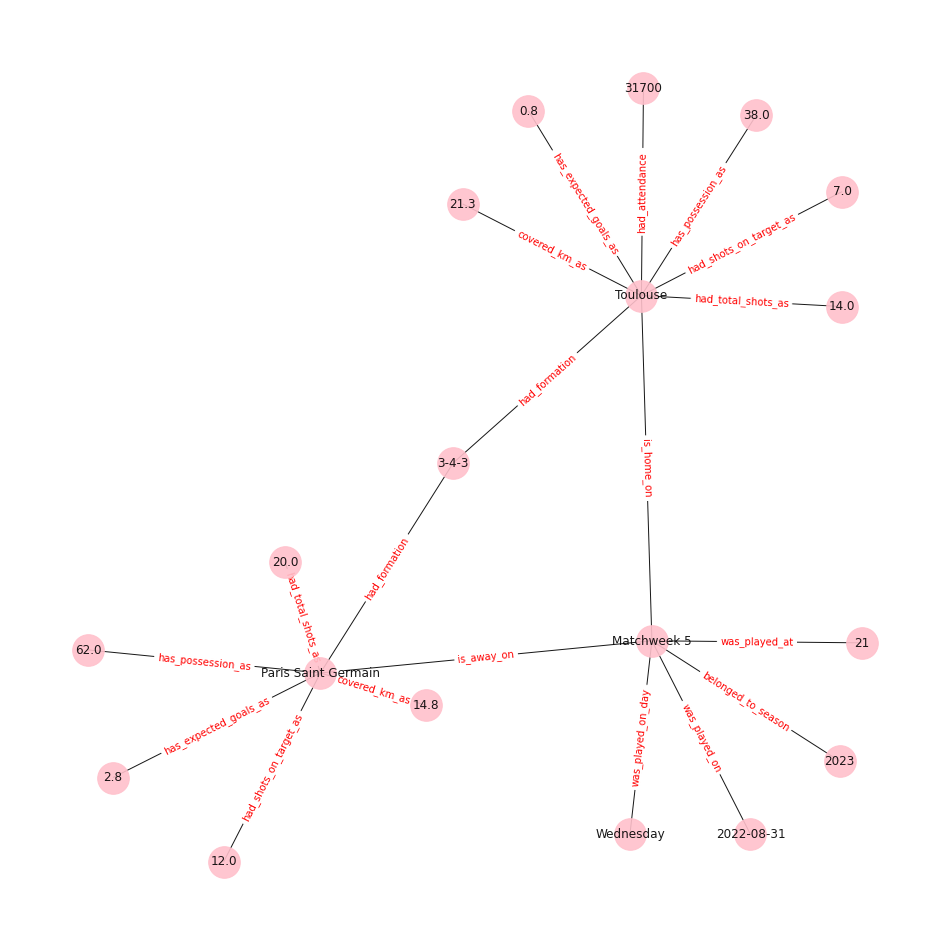

Using device:  cuda:0
USING CUDA


  0%|          | 0/1000 [00:00<?, ?epoch/s]

0.40540540540540543
2    0.387387
0    0.368082
1    0.244530
Name: result, dtype: float64
{'W': 2, 'D': 1, 'L': 0}
{2: 'W', 1: 'D', 0: 'L'}


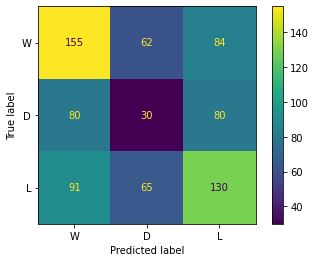

In [27]:
df = df_ligue_1.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Saint-Étienne": "Saint Etienne", 
              'Nîmes': "Nimes", 
              'Gazélec Ajaccio': "Gazelec Ajaccio", 
              'Paris S-G': "Paris Saint Germain", }

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]

triples = []
for _, row in df.iterrows():
    # match_info
    match_played_date = (row["round"], "was_played_on", row["date"])
    match_played_time = (row["round"], "was_played_at", row["time"])
    match_played_day = (row["round"], "was_played_on_day", row["day"])
    match_played_season = (row["round"], "belonged_to_season", row["season"])

    # Home and away information
    if row["venue"] == 'Home':
        match_attendance = (row["team"], "had_attendance", row["attendance"])
        home_team = (row["team"], "is_home_on", row["round"])
        away_team = (row["opponent"], "is_away_on", row["round"])
        home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        home_team_formation = (row["team"], "had_formation", row["formation_x"])
        away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
    else:
        match_attendance = (row["opponent"], "had_attendance", row["attendance"])
        home_team = (row["opponent"], "is_home_on", row["round"])
        away_team = (row["team"], "is_away_on", row["round"])
        home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        away_team_formation = (row["team"], "had_formation", row["formation_x"])

    
    triples.extend((match_played_date, 
                    match_played_time, 
                    match_played_day, 
                    match_played_season, 
                    home_team, away_team,
                    home_team_xg, away_team_xg,
                    home_team_poss, away_team_poss,
                    match_attendance, 
                    home_team_formation, away_team_formation, 
                    home_team_shots, away_team_shots, 
                    home_team_shots_on_target, away_team_shots_on_target, 
                    home_team_distance_covered, away_team_distance_covered, 
                    ))
    
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
print(triples_df.shape)

to_visualize_edges = triples_df[76:95]
print(triples_df.shape)
print(to_visualize_edges)

edge_list = []
edge_labels = {}
for _, row in to_visualize_edges.iterrows():
    h, r, t = row['from'], row['rel'], row['to']
    edge_list.append([h, t])
    edge_labels[(h, t)] = r

G = nx.Graph()
G.add_edges_from(edge_list)
pos = nx.spring_layout(G)
plt.figure(figsize=(13, 13))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)

plt.axis('off')
plt.show()

# G = nx.from_pandas_edgelist(to_visualize_edges, source='from', target='to', create_using=nx.MultiDiGraph(), edge_attr='rel')
# plt.figure(figsize=(13, 13))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', pos=pos)
# nx.draw_networkx_edge_labels(G, pos=pos)
# plt.show()

triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
triples_df = pd.DataFrame(triples_df, columns=['from', 'to', 'rel'])
kg_train = torchkge.data_structures.KnowledgeGraph(triples_df)
ent2ix = kg_train.ent2ix
rel2ix = kg_train.rel2ix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Hyper-parameters for Training to learn the embeddings
emb_dim = 100 # dimension of the tensor in the latent space
lr = 0.005 # learning rate to make gradient step 
n_epochs = 1000 # number of epochs
b_size = 1024 # size of data for each batch
margin = 0.5 # margin for the loss function

# Model and loss function
# model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
model = ComplExModel(emb_dim, kg_train.n_ent, kg_train.n_rel)
criterion = MarginLoss(margin)

# Use CUDA when available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
    print("USING CUDA")
else:
    print("POOR CPU")

# train with optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# negative samples for training to make sure we dont predict unwanted links
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=device)

# training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        if cuda.is_available():
            pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
        else:
            pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

if "ComplExModel" in str(model):
    re_ent_emb, im_ent_emb, re_rel_emb, im_rel_emb = model.get_embeddings()
    ent_emb = torch.hstack((re_ent_emb, im_ent_emb))
    rel_emb = torch.hstack((re_rel_emb, im_rel_emb))
else:
    ent_emb, rel_emb = model.get_embeddings()
	
entity_embedding_dict = {}
for k, v in ent2ix.items():
    entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

relation_embedding_dict = {}
for k, v in rel2ix.items():
    relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

def get_embeddings(team):
    return entity_embedding_dict.get(team, np.full(200, np.nan))

def get_features_target(mask):
    features = np.hstack((np.vstack(df[mask].team.apply(get_embeddings).values),
                   np.vstack(df[mask].opponent.apply(get_embeddings).values)))
    response = df[mask].result.values
    return features, response

clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((df["test"]))

clf_model = XGBClassifier(n_estimators=100, max_depth=5, objective="multi:softmax", verbose=True)
clf_model.fit(clf_X_train, y_train)
y_preds = clf_model.predict(clf_X_test)
print(accuracy_score(y_test, y_preds))

print(df[df["test"]].result.value_counts(normalize=True))
print(result_label_as_int)
int_to_result = {v: k for k, v in result_label_as_int.items()}
print(int_to_result)
y_test_str = [int_to_result[outcome] for outcome in y_test]
y_preds_str = [int_to_result[outcome] for outcome in y_preds]

cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

## Poisson - Ligue 1

0.477124183006536


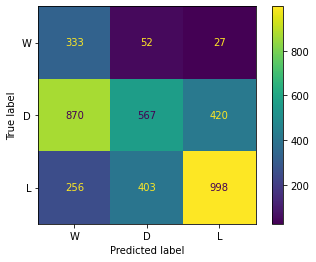

In [ ]:

df = df_ligue_1.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Saint-Étienne": "Saint Etienne", 
              'Nîmes': "Nimes", 
              'Gazélec Ajaccio': "Gazelec Ajaccio", 
              'Paris S-G': "Paris Saint Germain", }

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)

# add a home advantage bias
bias = 0.2
df['xg'] = df["xg"] + bias

# expected goals is our lambda parameter for poisson distribution
total_goals_possible = [*range(0,11)]
points_home = []
points_away = []
for _, row in df.iterrows():
    home_lambda = row["xg"]
    away_lambda = row["xga"]
    home_win_prob, away_win_prob, draw_prob = 0, 0, 0
    for home_goals in total_goals_possible:
        for away_goals in total_goals_possible:
            p = poisson.pmf(home_goals, home_lambda) * poisson.pmf(away_goals, away_lambda)
            if home_goals > away_goals: home_win_prob += p
            elif home_goals == away_goals: draw_prob += p
            else: away_win_prob += p

    home_points = 3 * home_win_prob + draw_prob
    away_points = 3 * away_win_prob + draw_prob
    points_home.append(home_points), points_away.append(away_points)

df['points_home'], df['points_away'] = points_home, points_away

df['points_diff'] = df['points_home'] - df['points_away']
points_conditions = [
    ((df['points_diff'] > 0) & (df['points_diff'] > 2)),
    ((df['points_diff'] > 0) & (df['points_diff'] < 2)),
    (df['points_diff'] < 0),
]

cat_values = ['W', 'D', 'L']
df['result_poisson'] = np.select(points_conditions, cat_values)
print(accuracy_score(df['result'], df['result_poisson']))
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
int_to_result = {v: k for k, v in result_label_as_int.items()}
y_test_str = df['result_poisson'].tolist()
y_preds_str =df['result'].tolist()
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

# Bundesliga

## KG - Bundesliga

Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'season', 'team', 'formation_y', 'poss_y', 'sh_y',
       'sot_y', 'dist_y'],
      dtype='object') (2488, 24)
(47272, 3)
(47272, 3)
             from                     rel           to
76    Matchweek 7           was_played_on   2022-09-17
77    Matchweek 7           was_played_at     Tea_time
78    Matchweek 7       was_played_on_day     Saturday
79    Matchweek 7      belonged_to_season         2023
80       Augsburg              is_home_on  Matchweek 7
81  Bayern Munich              is_away_on  Matchweek 7
82       Augsburg   has_expected_goals_as          1.7
83  Bayern Munich   has_expected_goals_as          1.6
84       Augsburg       has_possession_as         24.0
85  Bayern Munich       has_possession_as         76.0
86       Augsburg          had_attendance        30660
87       Augsburg           had_

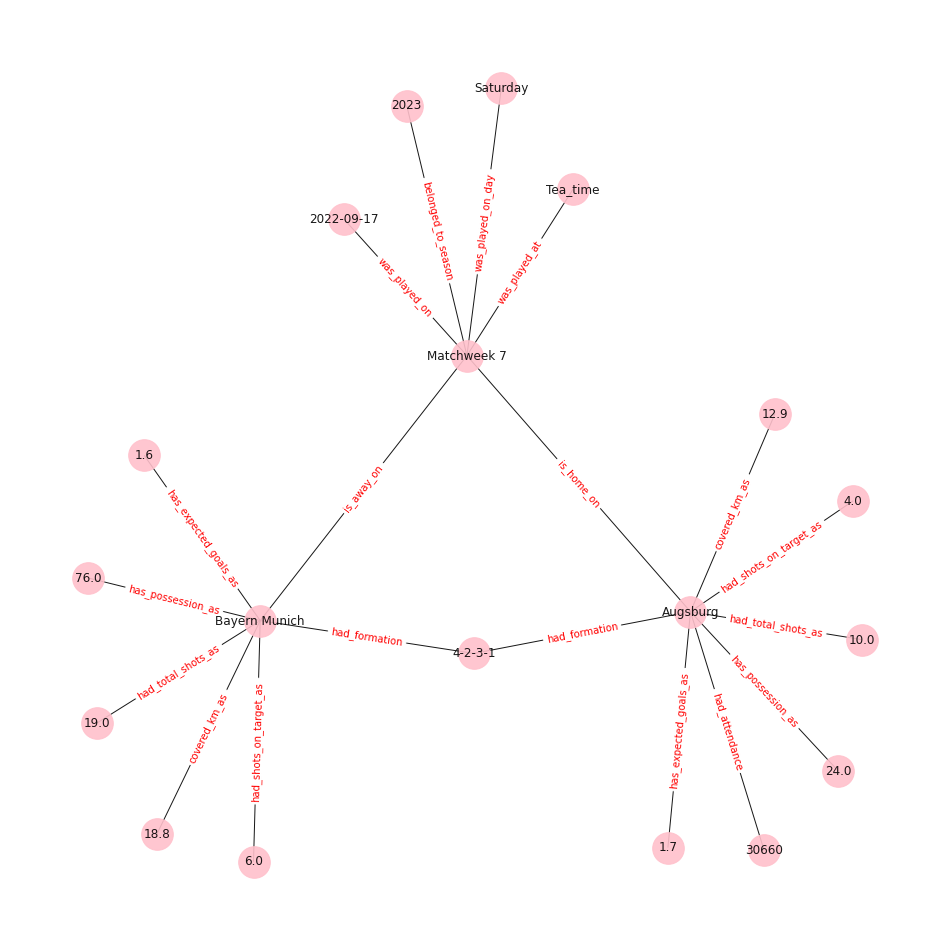

Using device:  cuda:0
USING CUDA


  0%|          | 0/1000 [00:00<?, ?epoch/s]

0.4720496894409938
2    0.387164
0    0.387164
1    0.225673
Name: result, dtype: float64
{'W': 2, 'D': 1, 'L': 0}
{2: 'W', 1: 'D', 0: 'L'}


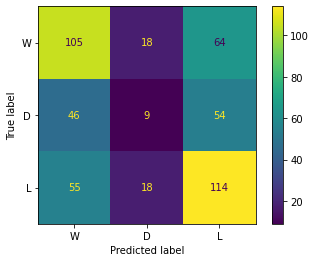

In [28]:
df = df_bundesliga.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

df = pd.merge(df, 
              df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
              how='inner', 
              left_on=['date', 'opponent'],
              right_on=['date', 'team'],
              suffixes=('_x', '_y'))

df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
print(df.columns, df.shape)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Eint Frankfurt": "Eintracht Frankfurt", 
              'Nürnberg': "Nurnberg", 
              'Greuther Fürth': 'Greuther Furth', 
              'Köln': 'Koln', 
              'Düsseldorf':'Dusseldorf',
              'Braunschweig': 'Eintracht Braunschweig',
              'Leverkusen': 'Bayer Leverkusen',
              "M'Gladbach": 'Monchengladbach',}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
df.replace({"result": result_label_as_int}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df['day'] = df['date'].dt.day_name()
df["date"] = df['date'].dt.date.astype("str")
df.drop(["time"], axis=1, inplace=True)
match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
df.replace({"hour": match_time_of_day}, inplace=True)
df.rename(columns = {'hour':'time'}, inplace = True)
# df["train"] = df.date < '2021-08-01'
# df['test'] = ~df["train"]
df["train"] = df.date < '2021-12-01'
df['test'] = ~df["train"]

triples = []
for _, row in df.iterrows():
    # match_info
    match_played_date = (row["round"], "was_played_on", row["date"])
    match_played_time = (row["round"], "was_played_at", row["time"])
    match_played_day = (row["round"], "was_played_on_day", row["day"])
    match_played_season = (row["round"], "belonged_to_season", row["season"])

    # Home and away information
    if row["venue"] == 'Home':
        match_attendance = (row["team"], "had_attendance", row["attendance"])
        home_team = (row["team"], "is_home_on", row["round"])
        away_team = (row["opponent"], "is_away_on", row["round"])
        home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        home_team_formation = (row["team"], "had_formation", row["formation_x"])
        away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
    else:
        match_attendance = (row["opponent"], "had_attendance", row["attendance"])
        home_team = (row["opponent"], "is_home_on", row["round"])
        away_team = (row["team"], "is_away_on", row["round"])
        home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
        away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
        home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
        away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
        home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
        away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
        home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
        away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
        home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
        away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
        home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        away_team_formation = (row["team"], "had_formation", row["formation_x"])

    
    triples.extend((match_played_date, 
                    match_played_time, 
                    match_played_day, 
                    match_played_season, 
                    home_team, away_team,
                    home_team_xg, away_team_xg,
                    home_team_poss, away_team_poss,
                    match_attendance, 
                    home_team_formation, away_team_formation, 
                    home_team_shots, away_team_shots, 
                    home_team_shots_on_target, away_team_shots_on_target, 
                    home_team_distance_covered, away_team_distance_covered, 
                    ))
    
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
print(triples_df.shape)

to_visualize_edges = triples_df[76:95]
print(triples_df.shape)
print(to_visualize_edges)

edge_list = []
edge_labels = {}
for _, row in to_visualize_edges.iterrows():
    h, r, t = row['from'], row['rel'], row['to']
    edge_list.append([h, t])
    edge_labels[(h, t)] = r

G = nx.Graph()
G.add_edges_from(edge_list)
pos = nx.spring_layout(G)
plt.figure(figsize=(13, 13))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=1000, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)

plt.axis('off')
plt.show()

# G = nx.from_pandas_edgelist(to_visualize_edges, source='from', target='to', create_using=nx.MultiDiGraph(), edge_attr='rel')
# plt.figure(figsize=(13, 13))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', pos=pos)
# nx.draw_networkx_edge_labels(G, pos=pos)
# plt.show()

triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
triples_df = triples_df.astype(str)
triples_df = pd.DataFrame(triples_df, columns=['from', 'to', 'rel'])
kg_train = torchkge.data_structures.KnowledgeGraph(triples_df)
ent2ix = kg_train.ent2ix
rel2ix = kg_train.rel2ix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Hyper-parameters for Training to learn the embeddings
emb_dim = 100 # dimension of the tensor in the latent space
lr = 0.005 # learning rate to make gradient step 
n_epochs = 1000 # number of epochs
b_size = 1024 # size of data for each batch
margin = 0.5 # margin for the loss function

# Model and loss function
# model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
model = ComplExModel(emb_dim, kg_train.n_ent, kg_train.n_rel)
criterion = MarginLoss(margin)

# Use CUDA when available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
    print("USING CUDA")
else:
    print("POOR CPU")

# train with optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# negative samples for training to make sure we dont predict unwanted links
sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=device)

# training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        if cuda.is_available():
            pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
        else:
            pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

if "ComplExModel" in str(model):
    re_ent_emb, im_ent_emb, re_rel_emb, im_rel_emb = model.get_embeddings()
    ent_emb = torch.hstack((re_ent_emb, im_ent_emb))
    rel_emb = torch.hstack((re_rel_emb, im_rel_emb))
else:
    ent_emb, rel_emb = model.get_embeddings()
	
entity_embedding_dict = {}
for k, v in ent2ix.items():
    entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

relation_embedding_dict = {}
for k, v in rel2ix.items():
    relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

def get_embeddings(team):
    return entity_embedding_dict.get(team, np.full(200, np.nan))

def get_features_target(mask):
    features = np.hstack((np.vstack(df[mask].team.apply(get_embeddings).values),
                   np.vstack(df[mask].opponent.apply(get_embeddings).values)))
    response = df[mask].result.values
    return features, response

clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((df["test"]))

clf_model = XGBClassifier(n_estimators=100, max_depth=5, objective="multi:softmax", verbose=True)
clf_model.fit(clf_X_train, y_train)
y_preds = clf_model.predict(clf_X_test)
print(accuracy_score(y_test, y_preds))

print(df[df["test"]].result.value_counts(normalize=True))
print(result_label_as_int)
int_to_result = {v: k for k, v in result_label_as_int.items()}
print(int_to_result)
y_test_str = [int_to_result[outcome] for outcome in y_test]
y_preds_str = [int_to_result[outcome] for outcome in y_preds]

cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

## Poisson - Bundesliga

0.4912912912912913


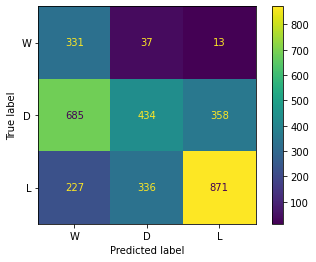

In [ ]:

df = df_bundesliga.copy()
df.drop(['Unnamed: 0', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
df['dist'].fillna(df['dist'].mode()[0], inplace=True)
df['time'].fillna(df['time'].mode()[0], inplace=True)
df.dropna(inplace=True)

class Missing_Dict(dict):
    __missing__ = lambda self, key: key

map_values = {"Eint Frankfurt": "Eintracht Frankfurt", 
              'Nürnberg': "Nurnberg", 
              'Greuther Fürth': 'Greuther Furth', 
              'Köln': 'Koln', 
              'Düsseldorf':'Dusseldorf',
              'Braunschweig': 'Eintracht Braunschweig',
              'Leverkusen': 'Bayer Leverkusen',
              "M'Gladbach": 'Monchengladbach',}

map_teams = Missing_Dict(**map_values)
df["team"] = df["team"].map(map_teams)
df["opponent"] = df["opponent"].map(map_teams)

# add a home advantage bias
bias = 0.2
df['xg'] = df["xg"] + bias

# expected goals is our lambda parameter for poisson distribution
total_goals_possible = [*range(0,11)]
points_home = []
points_away = []
for _, row in df.iterrows():
    home_lambda = row["xg"]
    away_lambda = row["xga"]
    home_win_prob, away_win_prob, draw_prob = 0, 0, 0
    for home_goals in total_goals_possible:
        for away_goals in total_goals_possible:
            p = poisson.pmf(home_goals, home_lambda) * poisson.pmf(away_goals, away_lambda)
            if home_goals > away_goals: home_win_prob += p
            elif home_goals == away_goals: draw_prob += p
            else: away_win_prob += p

    home_points = 3 * home_win_prob + draw_prob
    away_points = 3 * away_win_prob + draw_prob
    points_home.append(home_points), points_away.append(away_points)

df['points_home'], df['points_away'] = points_home, points_away

df['points_diff'] = df['points_home'] - df['points_away']
points_conditions = [
    ((df['points_diff'] > 0) & (df['points_diff'] > 2)),
    ((df['points_diff'] > 0) & (df['points_diff'] < 2)),
    (df['points_diff'] < 0),
]

cat_values = ['W', 'D', 'L']
df['result_poisson'] = np.select(points_conditions, cat_values)
print(accuracy_score(df['result'], df['result_poisson']))
result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
int_to_result = {v: k for k, v in result_label_as_int.items()}
y_test_str = df['result_poisson'].tolist()
y_preds_str =df['result'].tolist()
cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
disp.plot()
plt.show()

# Summary of Comparison

In [ ]:
# d = {'Leagues': ['La Liga', 'Seria A', 'EPL', 'Ligue 1', 'Bundesliga'], 
#      'TransE Accuracy':  [0.45, 0.50, 0.46, 0.41, 0.44],
#      'ComplEx Accuracy': [0.50, 0.50, 0.48, 0.43, 0.45],     
#      'Poisson Accuracy': [0.46, 0.47, 0.49, 0.47, 0.48]}

# df = pd.DataFrame(data=d)
# df.index = np.arange(1, len(df) + 1)
# df.to_latex()

# Scraping and extra code!

In [ ]:
### Code to make sure the team names are consistent in the data set (for eg: Man utd and Manchester united is not great for training, but, its changed to Man utd everywhere)
'''
df = df_epl.copy()
home_team_set = set(df['team'].unique())
opponent_team_set = set(df['opponent'].unique())
print(home_team_set)
print(opponent_team_set)
print(home_team_set ^ opponent_team_set)

class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Manchester United": "Manchester Utd", 
              'Queens Park Rangers': "QPR", 
              'Newcastle United': "Newcastle Utd", 
              'Huddersfield Town': "Huddersfield", 
              'Brighton and Hove Albion': "Brighton", 
              "West Ham United": 'West Ham', 
              'Tottenham Hotspur':'Tottenham',
              'West Bromwich Albion': 'West Brom',
              'Sheffield United': 'Sheffield Utd',
              "Nott'ham Forest": 'Nottingham Forest',
              'Wolverhampton Wanderers':'Wolves'}

mapping = MissingDict(**map_values)
df["team"] = df["team"].map(mapping)
df["opponent"] = df["opponent"].map(mapping)
home_team_set = set(df['team'].unique())
opponent_team_set = set(df['opponent'].unique())
print(home_team_set)
print(opponent_team_set)
print(home_team_set ^ opponent_team_set)
'''

'\ndf = df_epl.copy()\nhome_team_set = set(df[\'team\'].unique())\nopponent_team_set = set(df[\'opponent\'].unique())\nprint(home_team_set)\nprint(opponent_team_set)\nprint(home_team_set ^ opponent_team_set)\n\nclass MissingDict(dict):\n    __missing__ = lambda self, key: key\n\nmap_values = {"Manchester United": "Manchester Utd", \n              \'Queens Park Rangers\': "QPR", \n              \'Newcastle United\': "Newcastle Utd", \n              \'Huddersfield Town\': "Huddersfield", \n              \'Brighton and Hove Albion\': "Brighton", \n              "West Ham United": \'West Ham\', \n              \'Tottenham Hotspur\':\'Tottenham\',\n              \'West Bromwich Albion\': \'West Brom\',\n              \'Sheffield United\': \'Sheffield Utd\',\n              "Nott\'ham Forest": \'Nottingham Forest\',\n              \'Wolverhampton Wanderers\':\'Wolves\'}\n\nmapping = MissingDict(**map_values)\ndf["team"] = df["team"].map(mapping)\ndf["opponent"] = df["opponent"].map(mapping)\n

In [ ]:
### Code for calculating moving avg #####

'''
def moving_avg_for_5_games(group, cols, new_cols):
    group = group.sort_values("date")
    rolled_stats = group[cols].rolling(5, closed='left').mean().round(decimals = 3)
    group[new_cols] = rolled_stats
    group = group.dropna(subset=new_cols)
    return group

team_cols = ["sh_x", "sot_x", "dist_x"]
team_new_cols = [f"{c}_x_rolling" for c in team_cols]
team_roll = df.groupby("team_x").apply(lambda x: moving_avg_for_5_games(x, team_cols, team_new_cols))
team_roll = team_roll.droplevel('team_x')
team_roll.index = range(team_roll.shape[0])

opponent_cols = ["sh_y", "sot_y", "dist_y"]
opponent_new_cols = [f"{c}_y_rolling" for c in opponent_cols]
opponent_roll = team_roll.groupby("opponent_x").apply(lambda x: moving_avg_for_5_games(x, opponent_cols, opponent_new_cols))
opponent_roll = opponent_roll.droplevel('opponent_x')
opponent_roll.index = range(opponent_roll.shape[0])
'''

'\ndef moving_avg_for_5_games(group, cols, new_cols):\n    group = group.sort_values("date")\n    rolled_stats = group[cols].rolling(5, closed=\'left\').mean().round(decimals = 3)\n    group[new_cols] = rolled_stats\n    group = group.dropna(subset=new_cols)\n    return group\n\nteam_cols = ["sh_x", "sot_x", "dist_x"]\nteam_new_cols = [f"{c}_x_rolling" for c in team_cols]\nteam_roll = df.groupby("team_x").apply(lambda x: moving_avg_for_5_games(x, team_cols, team_new_cols))\nteam_roll = team_roll.droplevel(\'team_x\')\nteam_roll.index = range(team_roll.shape[0])\n\nopponent_cols = ["sh_y", "sot_y", "dist_y"]\nopponent_new_cols = [f"{c}_y_rolling" for c in opponent_cols]\nopponent_roll = team_roll.groupby("opponent_x").apply(lambda x: moving_avg_for_5_games(x, opponent_cols, opponent_new_cols))\nopponent_roll = opponent_roll.droplevel(\'opponent_x\')\nopponent_roll.index = range(opponent_roll.shape[0])\n'

In [ ]:
### code for Scraping ###

'''
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup

def main():
    years_we_want = [*range(2023, 2022, -1)]
    full_matches = []
    home_url = "https://fbref.com/en/comps/11/Serie-A-Stats"
    # home_url = "https://fbref.com/en/comps/12/La-Liga-Stats"

    for year in years_we_want:
        year_data = requests.get(home_url)
        year_soup = BeautifulSoup(year_data.text, "lxml")

        points_table = year_soup.select("table.stats_table")[0]
        all_club_links = points_table.find_all("a")

        href_of_clubs = []
        for club_link in all_club_links:
            href_of_clubs.append(club_link.get("href"))

        club_links = []
        for club_link in all_club_links:
            if "/squads" in club_link.get("href"):
                club_links.append(club_link.get("href"))

        full_club_links = []
        for club_link in club_links:
            full_club_links.append("https://fbref.com" + club_link)

        prev_link = year_soup.select("a.prev")[0]
        previous_season = prev_link.get("href")
        home_url = "https://fbref.com" + previous_season

        for club_url in full_club_links:
            club_data = requests.get(club_url)
            club_soup = BeautifulSoup(club_data.text, "lxml")
            club_name = club_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
            all_matches_df = pd.read_html(club_data.text, match="Scores & Fixtures")[0]
            match_logs_links = club_soup.find_all("a")

            match_logs_links_href = []
            for match_logs_link in match_logs_links:
                match_logs_links_href.append(match_logs_link.get("href"))

            shooting_links = []
            for match_logs_link_href in match_logs_links_href:
                if (
                    match_logs_link_href
                    and "all_comps/shooting" in match_logs_link_href
                ):
                    shooting_links.append(match_logs_link_href)

            full_shooting_links = []
            for shooting_link in shooting_links:
                full_shooting_links.append("https://fbref.com" + shooting_link)

            data_for_shooting_links = requests.get(full_shooting_links[0])
            try:
                shooting_df = pd.read_html(
                    data_for_shooting_links.text, match="Shooting"
                )[0]
                shooting_df.columns = shooting_df.columns.droplevel()
                team_match_shoot_df = pd.merge(
                    all_matches_df,
                    shooting_df[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]],
                    on="Date",
                    how="left",
                )

            except ValueError:

                continue

            team_match_shoot_df = team_match_shoot_df[
                team_match_shoot_df["Comp"] == "Serie A"
            ]
            team_match_shoot_df["Season"] = year
            team_match_shoot_df["Team"] = club_name
            full_matches.append(team_match_shoot_df)
            time.sleep(2)

    matches_df = pd.concat(full_matches)
    matches_df.columns = [col.lower() for col in matches_df.columns]
    matches_df.to_csv("matches_serie-a.csv")


if __name__ == "__main__":
    main()
'''

'\nimport time\nimport pandas as pd\nimport requests\nfrom bs4 import BeautifulSoup\n\ndef main():\n    years_we_want = [*range(2023, 2022, -1)]\n    full_matches = []\n    home_url = "https://fbref.com/en/comps/11/Serie-A-Stats"\n    # home_url = "https://fbref.com/en/comps/12/La-Liga-Stats"\n\n    for year in years_we_want:\n        year_data = requests.get(home_url)\n        year_soup = BeautifulSoup(year_data.text, "lxml")\n\n        points_table = year_soup.select("table.stats_table")[0]\n        all_club_links = points_table.find_all("a")\n\n        href_of_clubs = []\n        for club_link in all_club_links:\n            href_of_clubs.append(club_link.get("href"))\n\n        club_links = []\n        for club_link in all_club_links:\n            if "/squads" in club_link.get("href"):\n                club_links.append(club_link.get("href"))\n\n        full_club_links = []\n        for club_link in club_links:\n            full_club_links.append("https://fbref.com" + club_link)\n\